# SSL For Strong Gravitational Lensing

In [14]:
import numpy as np
import random
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image
import timm
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.optimizer import Optimizer
from sklearn import metrics
from typing import Callable
from torchvision import transforms
from tqdm import tqdm


def set_seed(seed_value):
    """Set seed for reproducibility."""
    # Python random module
    random.seed(seed_value)

    # Numpy
    np.random.seed(seed_value)

    # PyTorch
    torch.manual_seed(seed_value)


    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed_value)

set_seed(4224)

In [2]:
def loadingdata():
    
    file_list = glob.glob('/kaggle/input/real-hst/real_hst/*.npy')
    nl_file_list = glob.glob('/kaggle/input/real-hst/real_hst/nl*.npy')
    
    
    def normalize(img):
        min_value = img.min()
        max_value = img.max()
        
        img = (img - min_value) / (max_value - min_value)
        
        return img
    
    
    lens_img = []
    nlens_img = []
    
    for path in file_list:
        if path not in nl_file_list:
            lens_img.append(np.load(path))
    for path in nl_file_list:
        nlens_img.append(np.load(path))
    
    
    # labels 0: lens 1: non lens
    lens_y = np.zeros(len(lens_img))
    nlens_y = np.ones(len(nlens_img))
    
    labels = np.concatenate((lens_y, nlens_y))
        
    lensing_img = lens_img + nlens_img
    
    return lensing_img, labels

images, labels = loadingdata()   # 215 63 152

In [3]:
class CustomDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        img = self.data[idx]
        label = self.label[idx] 
        
        img = Image.fromarray(img, 'L')
        
        img = np.array(img)
        
        img = torch.from_numpy(img).unsqueeze(0)
        
        return img, label
    
data = CustomDataset(images, labels)
dataloader = DataLoader(data, batch_size = 32, shuffle=True)

## DINO
### Self Distilation with No labels
#### Dino is a SSL model fabricated to train two ViT(Original Paper) models, Student and Teacher. The Student models pertains with training and gradual updates of weights where the Teacher models weight are updated as the exponential moving average of students parameters. The model is genrally used to laverage Vision Tranformers for appreciable datasets. Though the dataset given doesn't have over 215 datums, this module is an atempt to demonstrate the use and potential of DINO architecture and Self Supervised Learning.

![](https://imgs.search.brave.com/cbWlSlNqosxgUEmsewd5gAyJONIff8UMQv8EEceTBJM/rs:fit:500:0:0/g:ce/aHR0cHM6Ly9pbWFn/ZXMuc3RvcnljaGll/Zi5jb20vYWNjb3Vu/dF8xNjc3MS9kaW5v/My0xLTQyNng0MjJf/MTczOTgyYjJmNjI5/MWVlMmE5YmI1ZGI2/ZDMzOGM0ZWZfODAw/LnBuZw)


#### The Dino architecture takes saperately augmented data input for student and teacher. The student model recieves augmentations of realtively bigger crops, where as the teacher model recives the input through different large and small crops. However the data we are dealing with consists of the Strong gravitational Lensing Images, these image would not be helped with such heavy augmentations. Thus using normal local augments would be enough given for the size of data we have.

In [4]:
class DINO(nn.Module):
    def __init__(self, student_arch: Callable, teacher_arch: Callable, device: torch.device, num_class):
        """
        Args:
            student_arch (nn.Module): ViT Network for student_arch
            teacher_arch (nn.Module): ViT Network for teacher_arch
            device: torch.device ('cuda' or 'cpu')
        """
        super(DINO, self).__init__()
    
        self.student = student_arch.to(device)
        self.teacher = teacher_arch.to(device)
        self.teacher.load_state_dict(self.student.state_dict())

        self.register_buffer('center', torch.zeros(1, num_class).to(device))

        for param in self.teacher.parameters():
            param.requires_grad = False

    @staticmethod
    def distillation_loss(student_output, teacher_output, center, tau_s, tau_t):
        """
        Calculates distillation loss with centering and sharpening (function H in pseudocode).
        """
        # Detach teacher output to stop gradients.
        teacher_output = teacher_output.detach()

        # Center and sharpen teacher's outputs
        teacher_probs = F.softmax((teacher_output - center) / tau_t, dim=1)

        # Sharpen student's outputs
        student_probs = F.log_softmax(student_output / tau_s, dim=1)

        # Calculate cross-entropy loss between student's and teacher's probabilities.
        loss = - (teacher_probs * student_probs).sum(dim=1).mean()
        return loss
    

    def teacher_update(self, beta: float):
        for teacher_params, student_params in zip(self.teacher.parameters(), self.student.parameters()):
            teacher_params.data.mul_(beta).add_(student_params.data, alpha=(1 - beta))


In [5]:
# def global_augment(images):
#     global_transform = transforms.Compose([
#         transforms.RandomResizedCrop(224, scale=(0.4, 1.0)),  
#         transforms.RandomHorizontalFlip(),
#         transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),  
#         transforms.RandomGrayscale(p=0.2),
#         transforms.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ])
#     return torch.stack([global_transform(img) for img in images])

# def multiple_local_augments(images, num_crops=6):
#     size = 96  # Smaller crops for local
#     local_transform = transforms.Compose([
#         transforms.RandomResizedCrop(size, scale=(0.05, 0.4)),  
#         transforms.RandomHorizontalFlip(),
#         transforms.ColorJitter(0.4, 0.4, 0.4, 0.1), 
#         transforms.RandomGrayscale(p=0.2),
#         transforms.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ])
#     # Apply the transformation multiple times to the same image
#     return torch.stack([local_transform(img) for img in images])

def local_augments1(images):
    local_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.04, 0.04, 0.04, 0.09),
        transforms.ToTensor(),
    ])
    images = [local_transform(img) for img in images]
    return torch.stack(images)

def local_augments2(images):
    local_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.04, 0.04, 0.04, 0.09),
        transforms.ToTensor(),
    ])

    images = [local_transform(img) for img in images]
    return torch.stack(images)

# Scaling the Model

The DINO model is generally considered a data hungry model, the more you train the student model the better the teacher model performs, the better the teacher model performs more easily the student model learns. Thus if you plan to train the model on large dataset. Consider the following parameters in the ```train_dino``` function.

```data_loader```: The Input Dataloader

```optimizer```: The Input Optimizer (Adam in out case) the learning rate is kept around 1e-3. No schedular is used for now.

```device```: 'cuda'

```tps``` and ```tst``` are the responsible for centering and sharpening in the distilation loss and needs tweaking for a larger dataset.
Centering: In the world of neural networks, centering often refers to normalizing the feature vectors. Specifically, for algorithms like DINO, centering involves subtracting the mean feature across different augmented views of the images in a batch. This is done so that the center of the distribution for the features becomes zero. This can help stabilize the training by keeping the features more consistent across different iterations and can prevent the model from developing a bias towards frequently observed features that don’t necessarily help with learning useful representations.

Sharpening: This is mainly effective for massive number of classes so no much relevant to current context. The purpose of sharpening is to make the distribution of the outputted features more peaked (less uniform). With DINO, sharpening is applied to the output of the student network by raising the output probabilities to the power of a value less than 1 (a temperature parameter < 1) before normalizing them. This has the effect of making the model more confident about its predictions, effectively increasing the weight of the highest probabilities and diminishing the rest. Sharpening helps in the contrastive learning process by making it easier for the model to differentiate between different features of the input data.

```beta```: For updaing the teachers parameters

```m```: For updating Center. Has to be experimented on Large Dataset for good results

In [6]:
def train_dino(dino: DINO,
               data_loader: DataLoader,
               optimizer: Optimizer,
               device: torch.device,
               num_epochs,
               tps=0.9,
               tpt= 0.9,
               beta= 0.9,
               m= 0.9,
               ):
        """
        Args:
        dino: DINO Module
        data_loader (nn.Module): Dataloader for training
        optimizer (nn.optimizer): Optimizer for optimization (SGD etc.)
        defice (torch.device): 'cuda', 'cpu'
        num_epochs: Number of Epochs
        tps (float): tau for sharpening student logits
        tpt: for sharpening teacher logits
        beta (float): moving average decay 
        m (float): center moveing average decay
        """
    
    
        for epoch in range(num_epochs):
            print(f"Epoch: {epoch+1}/{num_epochs}")
            Loss = 0
            for x, y in tqdm(data_loader):

                x1, x2 = local_augments1(x), local_augments2(x)  

                
                for param in dino.student.parameters():
                    param.requires_grad = True
            
                student_output1, student_output2 = dino.student(x1.to(device)), dino.student(x2.to(device))
                with torch.no_grad():
                    teacher_output1, teacher_output2 = dino.teacher(x1.to(device)), dino.teacher(x2.to(device))
                
                # Compute distillation loss
                loss = (dino.distillation_loss(student_output1.float(), teacher_output2.float(), dino.center, tps, tpt) +
                        dino.distillation_loss(student_output2.float(), teacher_output1.float(), dino.center, tps, tpt)) / 2

                
                Loss += loss.item()
                
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Update the teacher network parameters
                dino.teacher_update(beta)
                
                # Update the center
                with torch.no_grad():
                    dino.center = m * dino.center + (1 - m) * torch.cat([teacher_output1, teacher_output2], dim=0).mean(dim=0)
                
            Loss /= len(dataloader)
            
            tqdm.write(f"Training Loss: {Loss}")
                

In [7]:
num_class = 128
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_class)
model.patch_embed.proj = nn.Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
device = 'cuda'
dino_model = DINO(model, model, device, num_class)
EPOCHS = 4
optimizer = torch.optim.Adam(dino_model.parameters(), lr=1e-3)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [8]:
train_dino(dino_model, dataloader, optimizer, device, EPOCHS)

Epoch: 1/4


100%|██████████| 7/7 [00:16<00:00,  2.31s/it]


Training Loss: 1.8543959633189908
Epoch: 2/4


100%|██████████| 7/7 [00:15<00:00,  2.24s/it]


Training Loss: 0.8596708521779094
Epoch: 3/4


100%|██████████| 7/7 [00:15<00:00,  2.28s/it]


Training Loss: 0.2184393418719992
Epoch: 4/4


100%|██████████| 7/7 [00:16<00:00,  2.32s/it]

Training Loss: 2.0798263496586253


In [9]:
class Model(nn.Module):
    def __init__(self, dino):
        super(Model, self).__init__()
        self.dino = dino
#         self.ff = nn.Sequential(
#                             nn.Linear(512, 256),
#                             nn.ReLU(),
#                             nn.Linear(256, 128),
#                             nn.ReLU(),
#                             nn.Linear(128, 2))

        self.ff = nn.Sequential(
                            nn.Linear(128, 2))
    
    def forward(self, x):
        x = self.dino.student(x)
        x = self.ff(x)
        return x

In [10]:
model = Model(dino_model).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [63]:
optimizer.param_groups[0]['lr'] = 1e-2

In [11]:
epoch = 10
best_accuracy = 0
MODEL_PATH = "dino_model.pth"
for i in range(epoch):
    Loss = 0
    accuracy = 0
    for x, y in tqdm(dataloader):
        y = y.type(torch.LongTensor)
        y = y.to(device)
        
        x = local_augments1(x)
        x = x.type(torch.FloatTensor).to(device)
        
        score = model(x)
        
        loss = criterion(score , y)
        Loss += loss
    
        _ , target_idx = score.max(1) 
        correct_preds = (target_idx == y).float()
        acc = correct_preds.sum() / len(correct_preds)
        acc = (acc)*100
        accuracy += acc
        
    # backward
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        
    size = len(dataloader)
    accuracy = accuracy/size
    
    if accuracy > best_accuracy:
        best_accuracy=accuracy
        torch.save(model.state_dict(), MODEL_PATH)
    Loss = Loss/(size)
    
    tqdm.write(f"Loss: {Loss}, Accuracy: {accuracy}")
    

100%|██████████| 7/7 [00:05<00:00,  1.20it/s]


Loss: 3.6453094482421875, Accuracy: 50.65993881225586


100%|██████████| 7/7 [00:05<00:00,  1.22it/s]


Loss: 1.0895066261291504, Accuracy: 58.501556396484375


100%|██████████| 7/7 [00:05<00:00,  1.21it/s]


Loss: 1.0137184858322144, Accuracy: 62.2088508605957


100%|██████████| 7/7 [00:05<00:00,  1.19it/s]


Loss: 0.827755868434906, Accuracy: 57.60869598388672


100%|██████████| 7/7 [00:05<00:00,  1.17it/s]


Loss: 0.6988130807876587, Accuracy: 54.93012619018555


100%|██████████| 7/7 [00:06<00:00,  1.17it/s]


Loss: 0.6579998731613159, Accuracy: 71.35093688964844


100%|██████████| 7/7 [00:06<00:00,  1.16it/s]


Loss: 0.6106560230255127, Accuracy: 70.82686614990234


100%|██████████| 7/7 [00:06<00:00,  1.14it/s]


Loss: 0.6124445796012878, Accuracy: 71.35093688964844


100%|██████████| 7/7 [00:06<00:00,  1.13it/s]


Loss: 0.6315813064575195, Accuracy: 70.47749328613281


100%|██████████| 7/7 [00:06<00:00,  1.11it/s]


Loss: 0.6171764731407166, Accuracy: 70.82686614990234


In [12]:
model.load_state_dict(torch.load("/kaggle/working/dino_model.pth"))

<All keys matched successfully>

In [15]:
true_y = []
pred_y = []
y_pred_prob_list = []
model.eval()
for n , (img , y) in enumerate(tqdm(dataloader)):
    img = img.to(device)
    img = local_augments1(img)
    img = img.type(torch.cuda.FloatTensor)
    score = model(img)
    y_pred_prob_list.append(torch.softmax(score, dim = 1).detach().cpu().numpy())
    true_y.append(y.detach().cpu().numpy())
    
true = []
for i in true_y:
    for j in i:
        true.append(j)
prob = []
for i in y_pred_prob_list:
    for j in (i) :     
         prob.append(j)
            
fpr = { }
tpr = { }
roc_auc = { }
thresh ={ }

n_class = 2

for i in range(n_class):    
     fpr[i], tpr[i], thresh[i] = metrics.roc_curve(np.array(true), np.array(prob)[:,i], pos_label=i)
     roc_auc[i] = metrics.auc(fpr[i], tpr[i])

100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


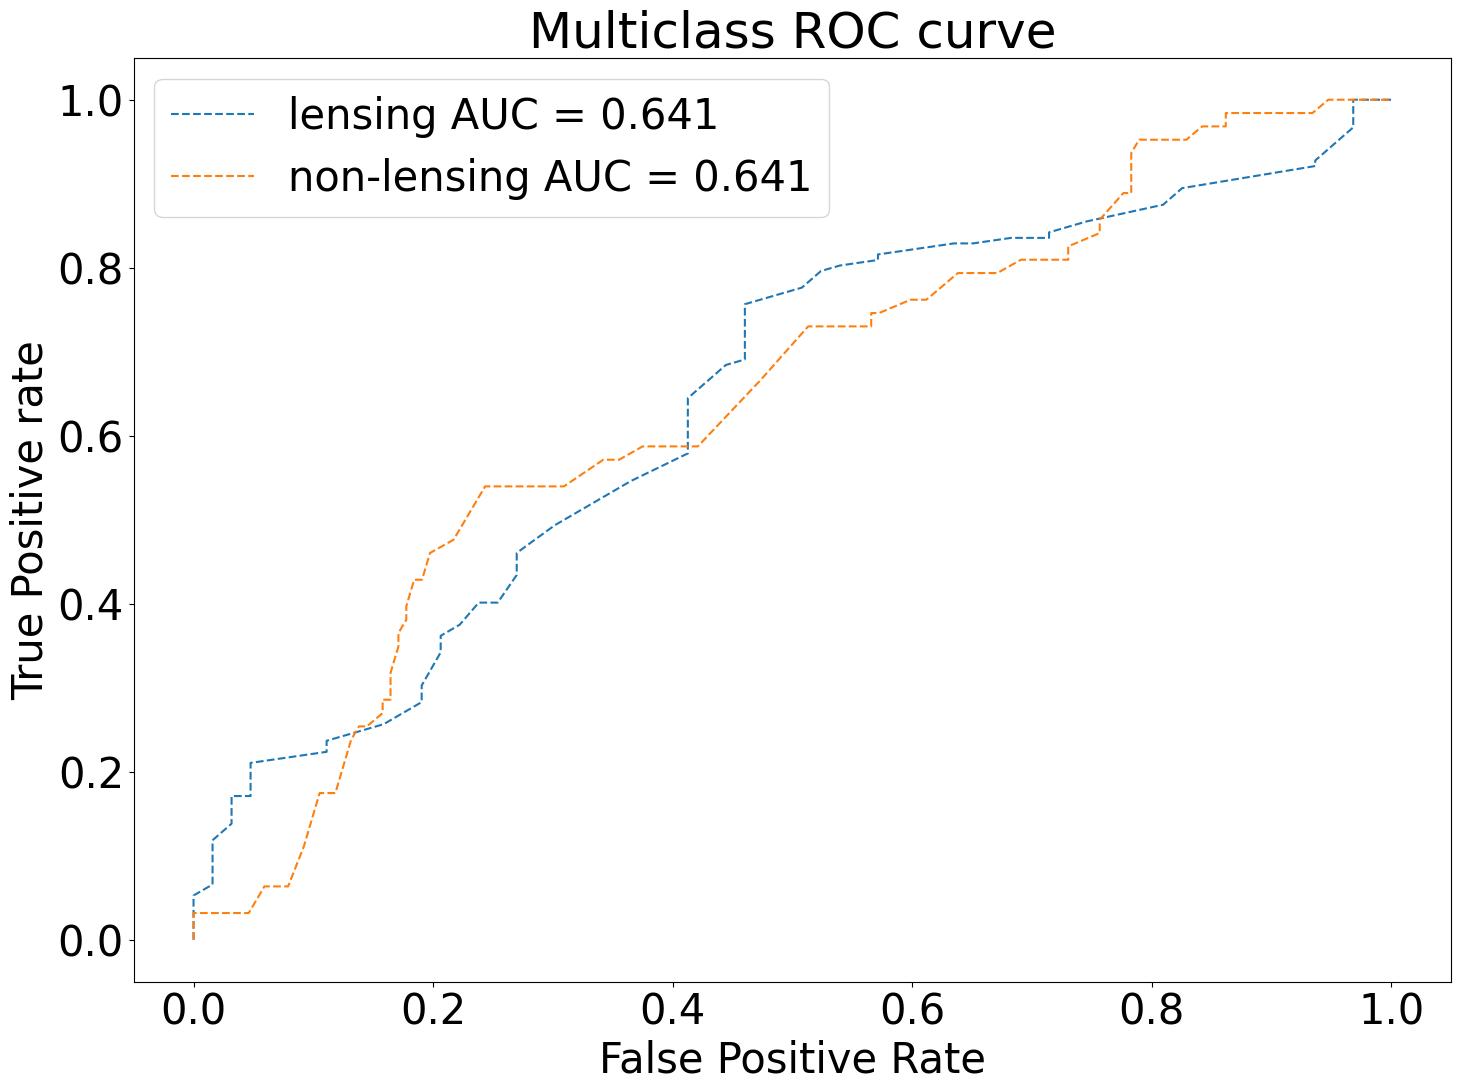

In [16]:
classes = ['lensing' , 'non-lensing']
plt.figure(figsize=(17,12))
plt.rcParams['font.size'] = '30'
for i in range(0,n_class):
    plt.plot(fpr[i], tpr[i], linestyle='--', label=f'{classes[i]} AUC = {roc_auc[i]:.3f}')

    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')

## Future Scope

#### **The Dino model levrages its student-teacher architecture to extract rich features, but the model consists of two ViTs making the model much denser leading to loose information a-midst training. An architecture should be dense enogh to extract key feature but also not overfit on the training dataset but that doesn't mean we can not use models which are capable of learning meaningful features without having large number of parameters.**

### **SimCLR**
#### SimCLR is a simple contrastive learning framework that has been very successful for SSL on CNNs. Adaptations have been made for ViTs, showing that ViTs can benefit from large batch sizes and contrastive loss in SSL just like CNNs.

#### There are many other potential vision based architectures leveraging hybrid transformers such as BYOL (Bootstrap Your Own Latent), MoCo v3 (Momentum Contrast v3) which have also shown promising results in the High Energy physics and can be explored for Strong Gravitational Lensing.



## Reference

https://arxiv.org/abs/2104.14294

https://arxiv.org/pdf/2008.12731.pdf

https://arxiv.org/pdf/1909.07346.pdf

https://arxiv.org/abs/2002.05709

https://arxiv.org/abs/2006.07733

https://arxiv.org/abs/1911.05722

